In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 读取数据
data = pd.read_csv("RFLFSODataFull.csv")

# 定义用于每个模型的变量列表
variables = {
    'Overall_FSO_Att': ['VisibilityMin','ParticulateMin','Temperature','Visibility','Distance'],
    'Overall_RFL_Att': ['RainIntensityMax','Distance','RainIntensity','AbsoluteHumidity'],
    'SynopCode_0_FSO_Att': ['AbsoluteHumidity', 'Visibility', 'Temperature', 'Distance'],
    'SynopCode_0_RFL_Att': ['Frequency','Visibility','AbsoluteHumidityMax','Temperature','AbsoluteHumidity','Distance'],
    'SynopCode_3_FSO_Att': ['RelativeHumidity','Time','VisibilityMax','Visibility','Distance','VisibilityMin'],
    'SynopCode_3_RFL_Att': ['TemperatureDifference','TemperatureMin', 'AbsoluteHumidityMax','TemperatureMax','Time','AbsoluteHumidityMin'],
    'SynopCode_4_FSO_Att': ['Visibility','TemperatureMin', 'Distance', 'ParticulateMin', 'Temperature', 'Particulate', 'ParticulateMax'],
    'SynopCode_4_RFL_Att': ['RainIntensity', 'RelativeHumidity'],
    'SynopCode_5_FSO_Att': ['Temperature', 'Visibility', 'ParticulateMax', 'Distance'],
    'SynopCode_5_RFL_Att': ['RainIntensityMax','Distance','AbsoluteHumidityMin','AbsoluteHumidityMax','AbsoluteHumidity'],
    'SynopCode_6_FSO_Att': ['Visibility','Temperature','ParticulateMax','Distance','Particulate'],
    'SynopCode_6_RFL_Att': ['Distance','Visibility','RainIntensityMax','AbsoluteHumidity','RainIntensity'],
    'SynopCode_7_FSO_Att': ['TemperatureDifference', 'Temperature', 'ParticulateMin','ParticulateMax','Particulate'],
    'SynopCode_7_RFL_Att': ['TemperatureDifference', 'Time',  'RainIntensityMin', 'WindSpeedMax'],
    'SynopCode_8_FSO_Att': ['AbsoluteHumidity','Distance','Visibility'],
    'SynopCode_8_RFL_Att': ['VisibilityMin','RainIntensityMin','AbsoluteHumidityMax','RainIntensity','AbsoluteHumidity']
}

# 训练和评估Random Forest模型的函数
def train_and_evaluate_rf(data, response_var, feature_vars, model_name):
    X = data[feature_vars]
    y = data[response_var]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
    rf_model.fit(X_train, y_train)
    
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"Train RMSE for {response_var}: {train_rmse}")
    print(f"Test RMSE for {response_var}: {test_rmse}")
    print(f"Train R² for {response_var}: {train_r2}")
    print(f"Test R² for {response_var}: {test_r2}")
    
    # 保存模型
    joblib.dump(rf_model, f"{model_name}.joblib")
    
    return rf_model, train_rmse, test_rmse, train_r2, test_r2

# 定义响应变量
response_vars = ['FSO_Att', 'RFL_Att']

# 训练和评估所有模型
for key, feature_vars in variables.items():
    if 'FSO_Att' in key:
        response_var = 'FSO_Att'
    else:
        response_var = 'RFL_Att'
    
    print(f"Training model for {key}...")
    train_and_evaluate_rf(data, response_var, feature_vars, model_name=key)

Training model for Overall_FSO_Att...
Train RMSE for FSO_Att: 0.34289013207587493
Test RMSE for FSO_Att: 0.9080079655658473
Train R² for FSO_Att: 0.9923146215377168
Test R² for FSO_Att: 0.9450482073487648
Training model for Overall_RFL_Att...
Train RMSE for RFL_Att: 0.3222272131195439
Test RMSE for RFL_Att: 0.837996053401655
Train R² for RFL_Att: 0.9912160859151845
Test R² for RFL_Att: 0.9407194953507352
Training model for SynopCode_0_FSO_Att...
Train RMSE for FSO_Att: 0.6171406319845104
Test RMSE for FSO_Att: 1.657222685779594
Train R² for FSO_Att: 0.9751043444227878
Test R² for FSO_Att: 0.8169522953764177
Training model for SynopCode_0_RFL_Att...
Train RMSE for RFL_Att: 0.5198762310424829
Test RMSE for RFL_Att: 1.3338803289825267
Train R² for RFL_Att: 0.9771354018773244
Test R² for RFL_Att: 0.8498028536481107
Training model for SynopCode_3_FSO_Att...
Train RMSE for FSO_Att: 0.4107198477299454
Test RMSE for FSO_Att: 1.088798936067433
Train R² for FSO_Att: 0.9889732718978074
Test R² fo

Loading model for SynopCode_0_FSO_Att from SynopCode_0_FSO_Att.joblib...
SynopCode_0_FSO_Att - RMSE: 0.850750158498707, R²: 0.9429841522009929
SynopCode_0_FSO_Att_overall - RMSE: 0.541264356673026, R²: 0.976921351808332
Loading model for SynopCode_0_RFL_Att from SynopCode_0_RFL_Att.joblib...
SynopCode_0_RFL_Att - RMSE: 0.46545930715881817, R²: 0.9670004578005459
SynopCode_0_RFL_Att_overall - RMSE: 0.45282358846253934, R²: 0.968767801114979
Loading model for SynopCode_3_FSO_Att from SynopCode_3_FSO_Att.joblib...
SynopCode_3_FSO_Att - RMSE: 0.5881056206829203, R²: 0.9960325085033822
SynopCode_3_FSO_Att_overall - RMSE: 0.5352240669108774, R²: 0.9967139315035098
Loading model for SynopCode_3_RFL_Att from SynopCode_3_RFL_Att.joblib...
SynopCode_3_RFL_Att - RMSE: 0.7076901252899023, R²: 0.953575896891965
SynopCode_3_RFL_Att_overall - RMSE: 0.2864204251102971, R²: 0.9923955953171035
Loading model for SynopCode_4_FSO_Att from SynopCode_4_FSO_Att.joblib...
SynopCode_4_FSO_Att - RMSE: 0.36623261

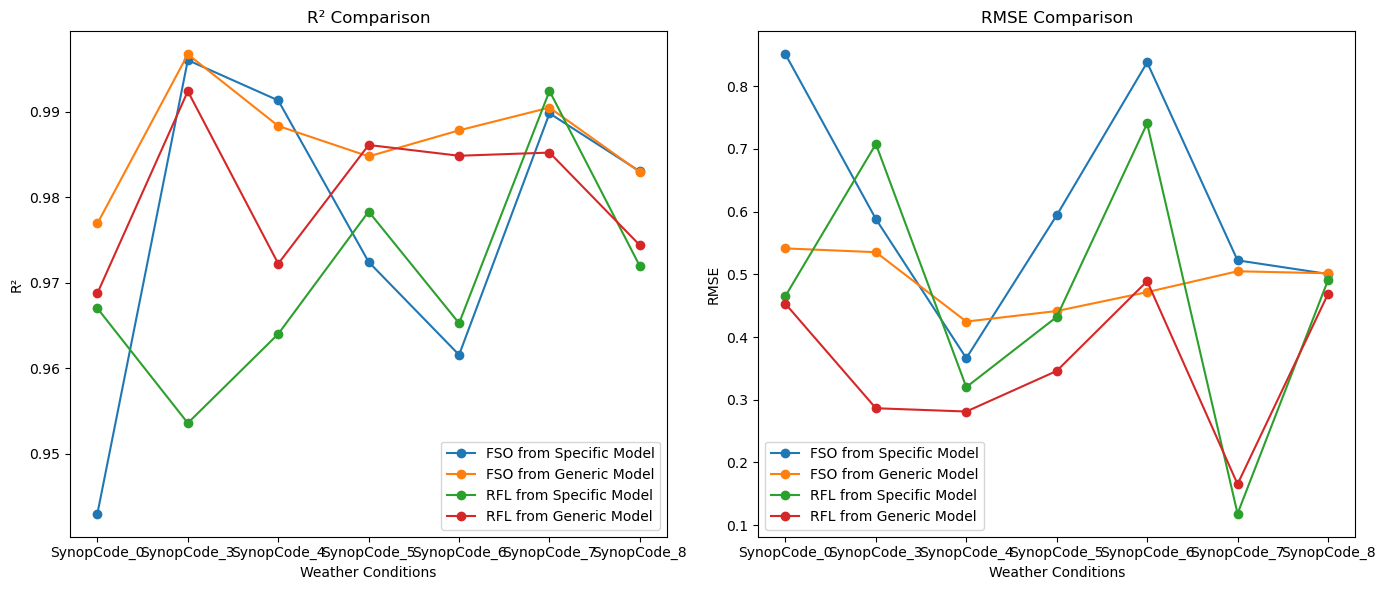

In [20]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 定义模型文件路径
model_files = {
    'Overall_FSO_Att': 'Overall_FSO_Att.joblib',
    'Overall_RFL_Att': 'Overall_RFL_Att.joblib',
    'SynopCode_0_FSO_Att': 'SynopCode_0_FSO_Att.joblib',
    'SynopCode_0_RFL_Att': 'SynopCode_0_RFL_Att.joblib',
    'SynopCode_3_FSO_Att': 'SynopCode_3_FSO_Att.joblib',
    'SynopCode_3_RFL_Att': 'SynopCode_3_RFL_Att.joblib',
    'SynopCode_4_FSO_Att': 'SynopCode_4_FSO_Att.joblib',
    'SynopCode_4_RFL_Att': 'SynopCode_4_RFL_Att.joblib',
    'SynopCode_5_FSO_Att': 'SynopCode_5_FSO_Att.joblib',
    'SynopCode_5_RFL_Att': 'SynopCode_5_RFL_Att.joblib',
    'SynopCode_6_FSO_Att': 'SynopCode_6_FSO_Att.joblib',
    'SynopCode_6_RFL_Att': 'SynopCode_6_RFL_Att.joblib',
    'SynopCode_7_FSO_Att': 'SynopCode_7_FSO_Att.joblib',
    'SynopCode_7_RFL_Att': 'SynopCode_7_RFL_Att.joblib',
    'SynopCode_8_FSO_Att': 'SynopCode_8_FSO_Att.joblib',
    'SynopCode_8_RFL_Att': 'SynopCode_8_RFL_Att.joblib'
}

# 定义变量字典
variables = {
    'Overall_FSO_Att': ['RelativeHumidity', 'TemperatureDifference', 'Distance', 'Visibility', 'Particulate', 'Temperature'],
    'Overall_RFL_Att': ['SYNOPCode', 'Time', 'TemperatureDifference', 'RainIntensityMin', 'AbsoluteHumidityMin', 'Visibility', 'RelativeHumidity', 'AbsoluteHumidity', 'RainIntensity'],
    'SynopCode_0_FSO_Att': ['AbsoluteHumidityMax', 'VisibilityMin', 'TemperatureMin', 'TemperatureMax', 'Temperature', 'Distance'],
    'SynopCode_0_RFL_Att': ['AbsoluteHumidityMin', 'Temperature', 'AbsoluteHumidityMax', 'Visibility', 'AbsoluteHumidity', 'Distance'],
    'SynopCode_3_FSO_Att': ['TemperatureDifference', 'TemperatureMin', 'Visibility', 'Time', 'VisibilityMin', 'Distance', 'VisibilityMax', 'Temperature'],
    'SynopCode_3_RFL_Att': ['AbsoluteHumidityMin', 'Frequency', 'TemperatureDifference', 'Temperature', 'TemperatureMax', 'AbsoluteHumidityMax'],
    'SynopCode_4_FSO_Att': ['TemperatureMin', 'Particulate', 'WindSpeedMax', 'Time', 'Temperature', 'Visibility'],
    'SynopCode_4_RFL_Att': ['RainIntensityMin', 'RelativeHumidity', 'Frequency', 'RainIntensityMin', 'AbsoluteHumidityMin', 'VisibilityMin', 'RainIntensity', 'AbsoluteHumidity'],
    'SynopCode_5_FSO_Att': ['TemperatureDifference', 'Time', 'Visibility', 'RelativeHumidity', 'Particulate', 'Distance'],
    'SynopCode_5_RFL_Att': ['Frequency', 'WindSpeed', 'VisibilityMax', 'RelativeHumidity', 'AbsoluteHumidity', 'RainIntensity'],
    'SynopCode_6_FSO_Att': ['Particulate', 'TemperatureMin', 'VisibilityMin', 'TemperatureMax', 'Distance', 'ParticulateMax'],
    'SynopCode_6_RFL_Att': ['Distance', 'AbsoluteHumidity', 'AbsoluteHumidityMin', 'RainIntensityMin', 'AbsoluteHumidityMax', 'RainIntensity'],
    'SynopCode_7_FSO_Att': ['TemperatureDifference', 'Temperature', 'Particulate'],
    'SynopCode_7_RFL_Att': ['RainIntensity', 'Frequency', 'Time', 'AbsoluteHumidity', 'RainIntensityMin', 'TemperatureDifference'],
    'SynopCode_8_FSO_Att': ['TemperatureDifference', 'Temperature', 'Particulate', 'RelativeHumidity', 'Visibility', 'Distance'],
    'SynopCode_8_RFL_Att': ['WindSpeed', 'TemperatureDifference', 'RelativeHumidity', 'Visibility', 'AbsoluteHumidity', 'RainIntensity']
}

# 读取数据
data = pd.read_csv("RFLFSODataFull.csv")

# 加载大模型
overall_fso_model = joblib.load(model_files['Overall_FSO_Att'])
overall_rfl_model = joblib.load(model_files['Overall_RFL_Att'])

# 初始化结果字典
results = {}

# 评估所有模型
for key, file in model_files.items():
    if 'Overall' in key:
        continue  # 跳过大模型

    print(f"Loading model for {key} from {file}...")
    model = joblib.load(file)
    feature_vars = variables[key]
    response_var = 'FSO_Att' if 'FSO_Att' in key else 'RFL_Att'
    
    synop_code = int(key.split('_')[1])
    subset_data = data[data['SYNOPCode'] == synop_code]
    X = subset_data[feature_vars]
    y = subset_data[response_var]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[key] = {'rmse': rmse, 'r2': r2}
    print(f"{key} - RMSE: {rmse}, R²: {r2}")
    
    # 评估大模型
    overall_X_test = subset_data[variables['Overall_' + response_var]]
    overall_X_test = overall_X_test.loc[X_test.index]  # 确保索引匹配
    
    if response_var == 'FSO_Att':
        overall_pred = overall_fso_model.predict(overall_X_test)
    else:
        overall_pred = overall_rfl_model.predict(overall_X_test)
    
    overall_rmse = np.sqrt(mean_squared_error(y_test, overall_pred))
    overall_r2 = r2_score(y_test, overall_pred)
    
    results[f"{key}_overall"] = {'rmse': overall_rmse, 'r2': overall_r2}
    print(f"{key}_overall - RMSE: {overall_rmse}, R²: {overall_r2}")

# 绘制对比图表
weather_conditions = ['SynopCode_0', 'SynopCode_3', 'SynopCode_4', 'SynopCode_5', 'SynopCode_6', 'SynopCode_7', 'SynopCode_8']
r2_values = {"FSO from Specific Model": [], "FSO from Generic Model": [], "RFL from Specific Model": [], "RFL from Generic Model": []}
rmse_values = {"FSO from Specific Model": [], "FSO from Generic Model": [], "RFL from Specific Model": [], "RFL from Generic Model": []}

for wc in weather_conditions:
    for var in ['FSO_Att', 'RFL_Att']:
        specific_key = f"{wc}_{var}"
        overall_key = f"{specific_key}_overall"
        
        if specific_key in results:
            r2_values[f"{var.split('_')[0]} from Specific Model"].append(results[specific_key]['r2'])
            rmse_values[f"{var.split('_')[0]} from Specific Model"].append(results[specific_key]['rmse'])
        if overall_key in results:
            r2_values[f"{var.split('_')[0]} from Generic Model"].append(results[overall_key]['r2'])
            rmse_values[f"{var.split('_')[0]} from Generic Model"].append(results[overall_key]['rmse'])

x_labels =['Clear Weather','Duststorm','Fog','Drizzle','Rain','Snow','Showers']
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for label, values in r2_values.items():
    plt.plot(x_labels, values, marker='o', label=label)
plt.xlabel('Weather Conditions')
plt.ylabel('R²')
plt.title('R² Comparison')
plt.legend()

plt.subplot(1, 2, 2)
for label, values in rmse_values.items():
    plt.plot(x_labels, values, marker='o', label=label)
plt.xlabel('Weather Conditions')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.legend()

plt.tight_layout()
plt.show()


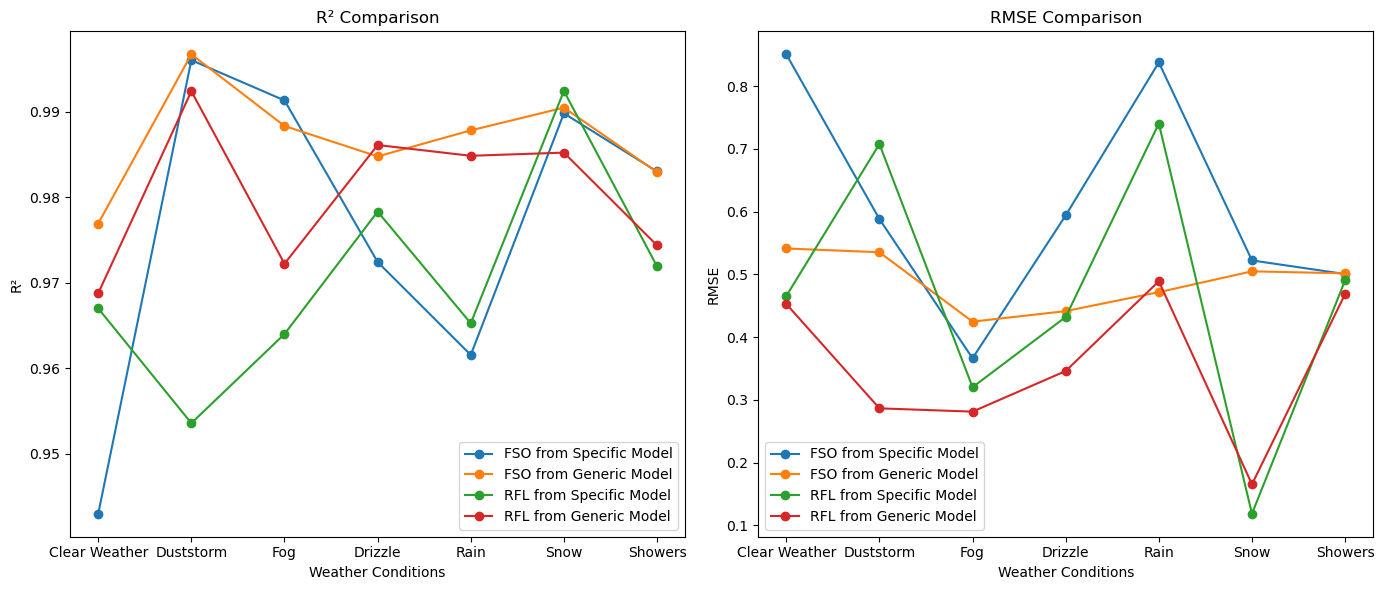

In [21]:
# 绘制对比图表
weather_conditions = ['SynopCode_0', 'SynopCode_3', 'SynopCode_4', 'SynopCode_5', 'SynopCode_6', 'SynopCode_7', 'SynopCode_8']
r2_values = {"FSO from Specific Model": [], "FSO from Generic Model": [], "RFL from Specific Model": [], "RFL from Generic Model": []}
rmse_values = {"FSO from Specific Model": [], "FSO from Generic Model": [], "RFL from Specific Model": [], "RFL from Generic Model": []}

for wc in weather_conditions:
    for var in ['FSO_Att', 'RFL_Att']:
        specific_key = f"{wc}_{var}"
        overall_key = f"{specific_key}_overall"
        
        if specific_key in results:
            r2_values[f"{var.split('_')[0]} from Specific Model"].append(results[specific_key]['r2'])
            rmse_values[f"{var.split('_')[0]} from Specific Model"].append(results[specific_key]['rmse'])
        if overall_key in results:
            r2_values[f"{var.split('_')[0]} from Generic Model"].append(results[overall_key]['r2'])
            rmse_values[f"{var.split('_')[0]} from Generic Model"].append(results[overall_key]['rmse'])

x_labels =['Clear Weather','Duststorm','Fog','Drizzle','Rain','Snow','Showers']
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for label, values in r2_values.items():
    plt.plot(x_labels, values, marker='o', label=label)
plt.xlabel('Weather Conditions')
plt.ylabel('R²')
plt.title('R² Comparison')
plt.legend()

plt.subplot(1, 2, 2)
for label, values in rmse_values.items():
    plt.plot(x_labels, values, marker='o', label=label)
plt.xlabel('Weather Conditions')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.legend()

plt.tight_layout()
plt.show()
